In [1]:
%pip install opencv-python numpy scipy moviepy tqdm matplotlib PyWavelets scikit-image tensorflow keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import pywt
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dense, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

Load videos and extract frames

In [3]:
DATASET_PATH = "./Celeb-DF"
OUTPUT_FRAMES_PATH = "extracted_frames"
FRAME_INTERVAL = 5

os.makedirs(OUTPUT_FRAMES_PATH, exist_ok=True)

def extract_frames(video_path, save_path, interval=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success, frame = cap.read()
    
    while success:
        if frame_count % interval == 0:
            frame_filename = os.path.join(save_path, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
        success, frame = cap.read()
        frame_count += 1
    
    cap.release()

for folder in ["Celeb-real", "YouTube-real", "Celeb-synthesis"]:
    folder_path = os.path.join(DATASET_PATH, folder)
    output_folder = os.path.join(OUTPUT_FRAMES_PATH, folder)
    os.makedirs(output_folder, exist_ok=True)

    for video_name in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
        video_path = os.path.join(folder_path, video_name)
        video_output_path = os.path.join(output_folder, video_name.split('.')[0])
        os.makedirs(video_output_path, exist_ok=True)

        extract_frames(video_path, video_output_path, FRAME_INTERVAL)

print("Frame extraction complete.")

Processing Celeb-synthesis: 100%|██████████| 795/795 [05:05<00:00,  2.60it/s]

Frame extraction complete.


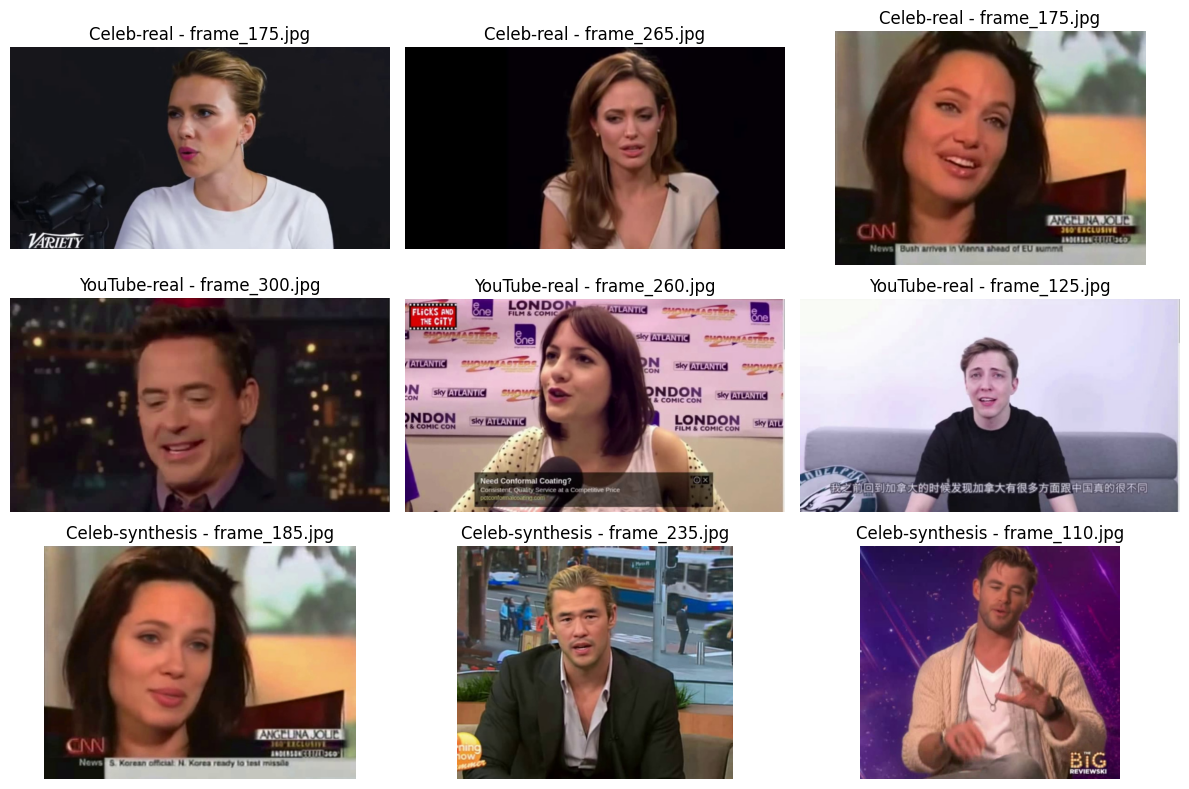

In [4]:
EXTRACTED_FRAMES_PATH = "extracted_frames"
FOLDERS = ["Celeb-real", "YouTube-real", "Celeb-synthesis"]

def get_random_frames(folder_path, num_frames=3):
    all_videos = os.listdir(folder_path)
    if len(all_videos) == 0:
        return []
    
    selected_videos = random.sample(all_videos, min(len(all_videos), num_frames))
    frames = []

    for video in selected_videos:
        video_folder = os.path.join(folder_path, video)
        if os.path.isdir(video_folder):
            frame_files = os.listdir(video_folder)
            if frame_files:
                random_frame = random.choice(frame_files)
                frame_path = os.path.join(video_folder, random_frame)
                frames.append(frame_path)
    
    return frames

fig, axes = plt.subplots(len(FOLDERS), 3, figsize=(12, 8))

for i, folder in enumerate(FOLDERS):
    folder_path = os.path.join(EXTRACTED_FRAMES_PATH, folder)
    random_frames = get_random_frames(folder_path)

    for j, frame_path in enumerate(random_frames):
        img = cv2.imread(frame_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"{folder} - {os.path.basename(frame_path)}")

plt.tight_layout()
plt.show()

Apply DWT + DCT for Watermarking

Using frame: extracted_frames/Celeb-real\id3_0001\frame_175.jpg


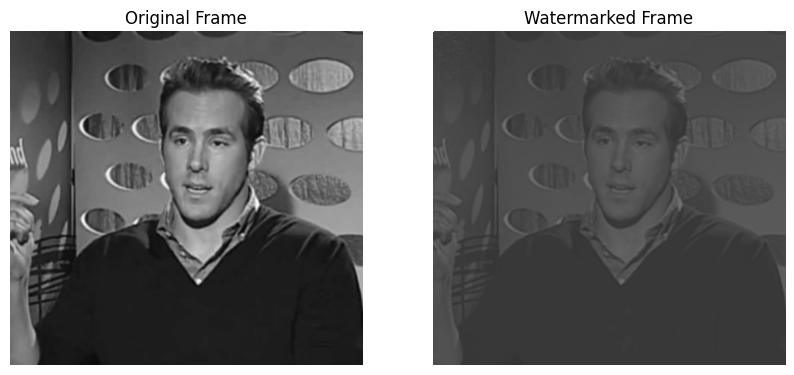

In [5]:
frame_folder = "extracted_frames/Celeb-real"

if not os.path.exists(frame_folder):
    raise FileNotFoundError(f"Frame directory not found: {frame_folder}")

video_folders = [f for f in os.listdir(frame_folder) if os.path.isdir(os.path.join(frame_folder, f))]

if not video_folders:
    raise FileNotFoundError("No video folders found in extracted_frames/Celeb-real")

selected_video = random.choice(video_folders)
video_path = os.path.join(frame_folder, selected_video)

frame_files = [f for f in os.listdir(video_path) if f.endswith(".jpg") or f.endswith(".png")]

if not frame_files:
    raise FileNotFoundError(f"No frames found in {video_path}")

sample_frame_path = os.path.join(video_path, random.choice(frame_files))
print(f"Using frame: {sample_frame_path}")

image = cv2.imread(sample_frame_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise ValueError("Error loading image. Check file path or file format.")

def apply_dwt(image):
    coeffs = pywt.dwt2(image, 'haar')  
    LL, (LH, HL, HH) = coeffs
    return LL, LH, HL, HH, coeffs

def apply_dct(block):
    return cv2.dct(np.float32(block))

def apply_idct(block):
    return cv2.idct(block)

def embed_watermark(LL_subband, watermark):
    dct_LL = apply_dct(LL_subband)

    wm_resized = cv2.resize(watermark, (dct_LL.shape[1], dct_LL.shape[0]))

    alpha = 0.05 
    dct_LL += alpha * wm_resized

    return apply_idct(dct_LL)

def reconstruct_image(LL, LH, HL, HH):
    coeffs = (LL, (LH, HL, HH))
    return pywt.idwt2(coeffs, 'haar')

watermark = np.random.randint(0, 256, (50, 50), dtype=np.uint8)

LL, LH, HL, HH, coeffs = apply_dwt(image)

watermarked_LL = embed_watermark(LL, watermark)

watermarked_image = reconstruct_image(watermarked_LL, LH, HL, HH)

cv2.imwrite("watermarked_frame.jpg", watermarked_image)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Frame")
axes[0].axis("off")

axes[1].imshow(watermarked_image, cmap='gray')
axes[1].set_title("Watermarked Frame")
axes[1].axis("off")

plt.show()

Watermark Extraction & Validation

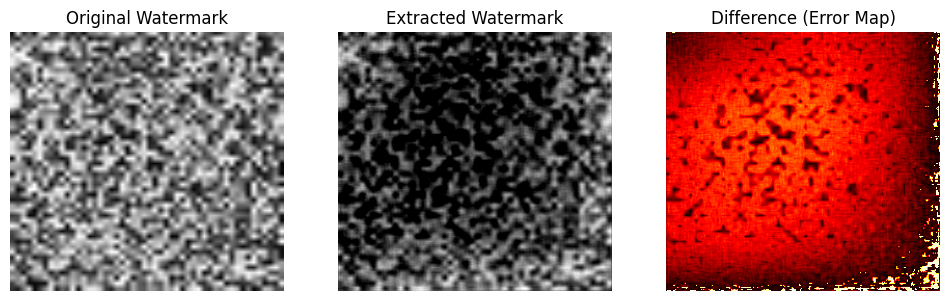

📏 MSE: 110.2887
📊 SSIM: 0.5778 (Closer to 1 is better)


In [6]:
def extract_watermark(watermarked_LL, original_LL, alpha=0.05):
    dct_watermarked_LL = cv2.dct(np.float32(watermarked_LL))
    dct_original_LL = cv2.dct(np.float32(original_LL))

    extracted_wm = (dct_watermarked_LL - dct_original_LL) / alpha

    extracted_wm = np.clip(extracted_wm, 0, 255) 
    return extracted_wm.astype(np.uint8)

watermarked_image = cv2.imread("watermarked_frame.jpg", cv2.IMREAD_GRAYSCALE)
if watermarked_image is None:
    raise FileNotFoundError("Watermarked frame not found.")

watermarked_LL, _, _, _, _ = apply_dwt(watermarked_image)
original_LL, _, _, _, _ = apply_dwt(image)  

extracted_watermark = extract_watermark(watermarked_LL, original_LL)

original_watermark_resized = cv2.resize(watermark, (extracted_watermark.shape[1], extracted_watermark.shape[0]))

mse_value = np.mean((original_watermark_resized - extracted_watermark) ** 2)

ssim_value = ssim(original_watermark_resized, extracted_watermark, data_range=extracted_watermark.max() - extracted_watermark.min())

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_watermark_resized, cmap='gray')
axes[0].set_title("Original Watermark")
axes[0].axis("off")

axes[1].imshow(extracted_watermark, cmap='gray')
axes[1].set_title("Extracted Watermark")
axes[1].axis("off")

difference = np.abs(original_watermark_resized - extracted_watermark)
axes[2].imshow(difference, cmap='hot')
axes[2].set_title("Difference (Error Map)")
axes[2].axis("off")

plt.show()

print(f"📏 MSE: {mse_value:.4f}")
print(f"📊 SSIM: {ssim_value:.4f} (Closer to 1 is better)")

GAN Architecture

In [7]:
frame_folder = "extracted_frames/Celeb-real"

video_folders = [f for f in os.listdir(frame_folder) if os.path.isdir(os.path.join(frame_folder, f))]
selected_video = random.choice(video_folders)
video_path = os.path.join(frame_folder, selected_video)

frame_files = [f for f in os.listdir(video_path) if f.endswith(".jpg") or f.endswith(".png")]
sample_frame_path = os.path.join(video_path, random.choice(frame_files))

image = cv2.imread(sample_frame_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (128, 128)) 


image = image / 255.0  
image = np.expand_dims(image, axis=-1)  
image = np.expand_dims(image, axis=0)   

def build_generator():
    input_layer = Input(shape=(128, 128, 1))
    
    x = Conv2D(64, (3, 3), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)  

    return Model(input_layer, x, name="Generator")

def build_discriminator():
    input_layer = Input(shape=(128, 128, 1))
    
    x = Conv2D(64, (3, 3), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x) 
    
    return Model(input_layer, x, name="Discriminator")

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
gan_input = Input(shape=(128, 128, 1))
watermarked_output = generator(gan_input)
gan_output = discriminator(watermarked_output)

gan_model = Model(gan_input, gan_output)
gan_model.compile(optimizer='adam', loss='binary_crossentropy')

generator.summary()
discriminator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 1)    │         1,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,649 (295.50 KB)

 Trainable params: 75,649 (295.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1048576)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │     1,048,577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,049,217 (4.00 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,049,217 (4.00 MB)

In [8]:
frame_folder = "extracted_frames/Celeb-real"

def load_frames(num_samples=1000, frame_size=(128, 128)):
    images = []
    watermarked_images = []
    
    video_folders = [f for f in os.listdir(frame_folder) if os.path.isdir(os.path.join(frame_folder, f))]
    if not video_folders:
        raise ValueError("No video folders found in the specified directory.")

    for i in range(num_samples):
        selected_video = random.choice(video_folders)
        video_path = os.path.join(frame_folder, selected_video)

        frame_files = [f for f in os.listdir(video_path) if f.endswith((".jpg", ".png"))]
        if not frame_files:
            continue  # Skip empty folders

        sample_frame_path = os.path.join(video_path, random.choice(frame_files))

        image = cv2.imread(sample_frame_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue  # Skip invalid frames
        
        # Resize and normalize
        image = cv2.resize(image, frame_size) / 255.0  
        image = np.expand_dims(image, axis=-1)  

        # Generate a light watermark
        watermark = np.random.uniform(0, 0.1, frame_size + (1,))  
        watermarked_image = np.clip(image + watermark, 0, 1)  

        images.append(image)
        watermarked_images.append(watermarked_image)

        # Print progress every 100 samples
        if (i + 1) % 100 == 0:
            print(f"Loaded {i + 1}/{num_samples} frames...")

    images = np.array(images)
    watermarked_images = np.array(watermarked_images)

    print(f"✅ Loaded {len(images)} real frames and {len(watermarked_images)} watermarked frames.")
    return images, watermarked_images

# Load 2000 frames
real_images, watermarked_images = load_frames(2000)

Loaded 100/2000 frames...
Loaded 200/2000 frames...
Loaded 300/2000 frames...
Loaded 400/2000 frames...
Loaded 500/2000 frames...
Loaded 600/2000 frames...
Loaded 700/2000 frames...
Loaded 800/2000 frames...
Loaded 900/2000 frames...
Loaded 1000/2000 frames...
Loaded 1100/2000 frames...
Loaded 1200/2000 frames...
Loaded 1300/2000 frames...
Loaded 1400/2000 frames...
Loaded 1500/2000 frames...
Loaded 1600/2000 frames...
Loaded 1700/2000 frames...
Loaded 1800/2000 frames...
Loaded 1900/2000 frames...
Loaded 2000/2000 frames...
✅ Loaded 2000 real frames and 2000 watermarked frames.


Epoch 0/5000 - D Loss: 0.6931, G Loss: 0.6795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📏 Epoch 0: PSNR = 5.05 dB, SSIM = 0.0770


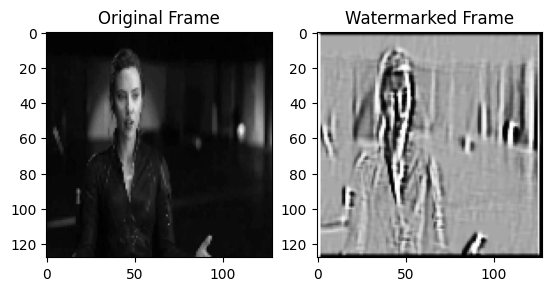

Epoch 100/5000 - D Loss: 0.6931, G Loss: 0.6759
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 100: PSNR = 8.90 dB, SSIM = 0.1109


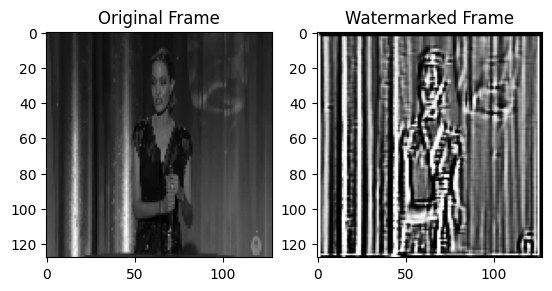

Epoch 200/5000 - D Loss: 0.6931, G Loss: 0.6731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
📏 Epoch 200: PSNR = 5.93 dB, SSIM = 0.0291


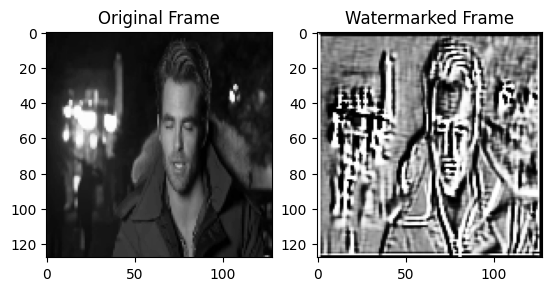

Epoch 300/5000 - D Loss: 0.6931, G Loss: 0.6710
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 300: PSNR = 8.01 dB, SSIM = 0.0452


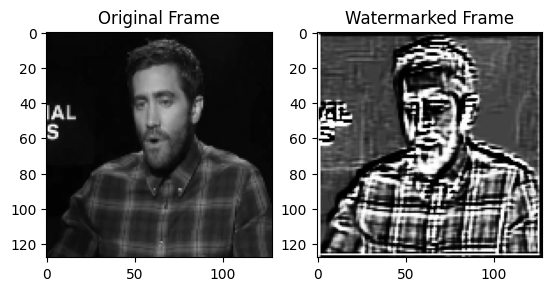

Epoch 400/5000 - D Loss: 0.6931, G Loss: 0.6695
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 400: PSNR = 8.13 dB, SSIM = 0.0554


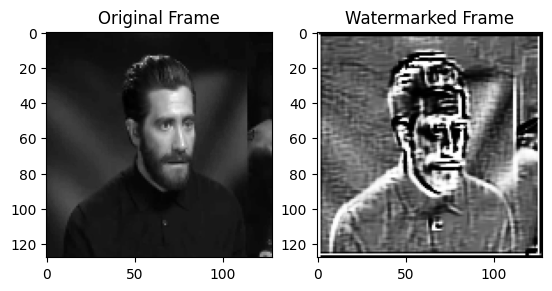

Epoch 500/5000 - D Loss: 0.6931, G Loss: 0.6681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
📏 Epoch 500: PSNR = 6.57 dB, SSIM = 0.0805


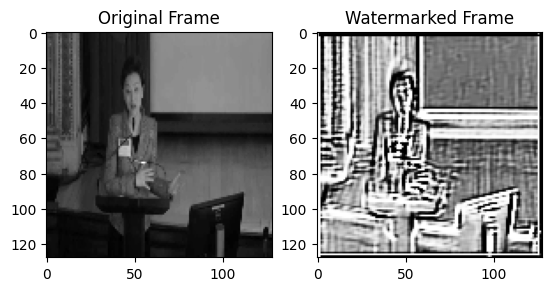

Epoch 600/5000 - D Loss: 0.6931, G Loss: 0.6670
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 600: PSNR = 5.79 dB, SSIM = 0.0293


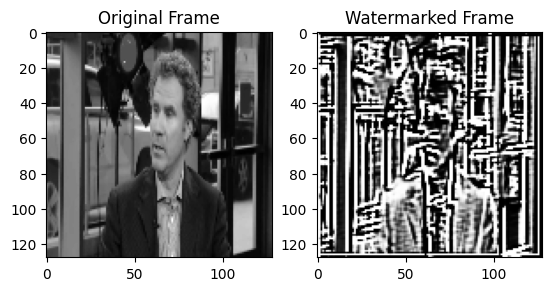

Epoch 700/5000 - D Loss: 0.6931, G Loss: 0.6660
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 700: PSNR = 7.17 dB, SSIM = 0.0407


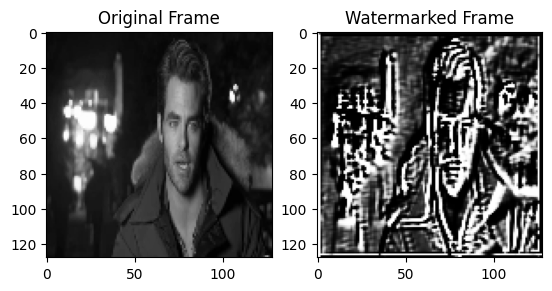

Epoch 800/5000 - D Loss: 0.6931, G Loss: 0.6652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
📏 Epoch 800: PSNR = 8.04 dB, SSIM = 0.0428


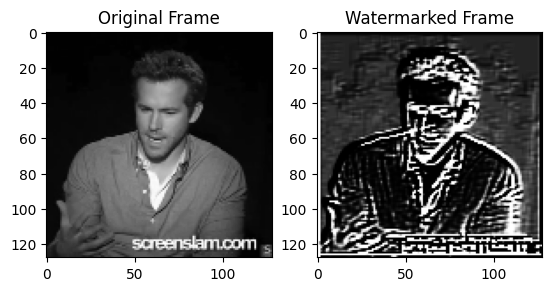

Epoch 900/5000 - D Loss: 0.6930, G Loss: 0.6645
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 900: PSNR = 4.68 dB, SSIM = 0.0258


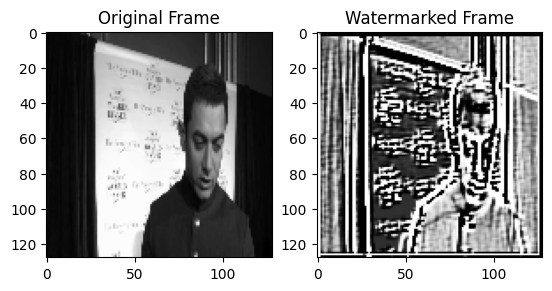

Epoch 1000/5000 - D Loss: 0.6930, G Loss: 0.6638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
📏 Epoch 1000: PSNR = 5.16 dB, SSIM = 0.0474


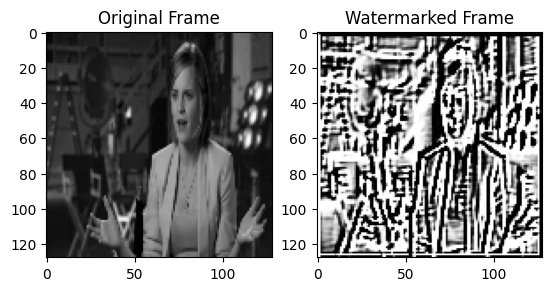

Epoch 1100/5000 - D Loss: 0.6930, G Loss: 0.6632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 1100: PSNR = 3.81 dB, SSIM = -0.0013


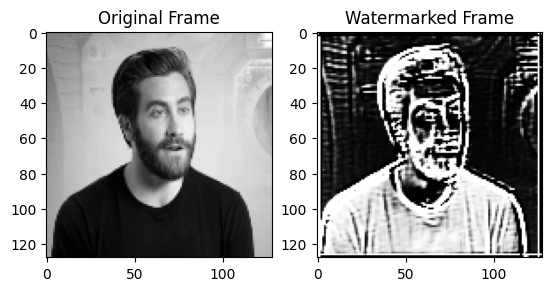

Epoch 1200/5000 - D Loss: 0.6930, G Loss: 0.6628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
📏 Epoch 1200: PSNR = 6.19 dB, SSIM = 0.0407


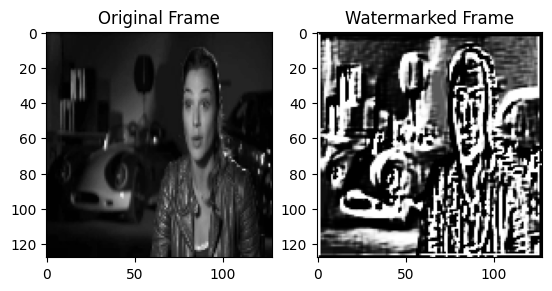

Epoch 1300/5000 - D Loss: 0.6930, G Loss: 0.6623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 1300: PSNR = 2.72 dB, SSIM = 0.1416


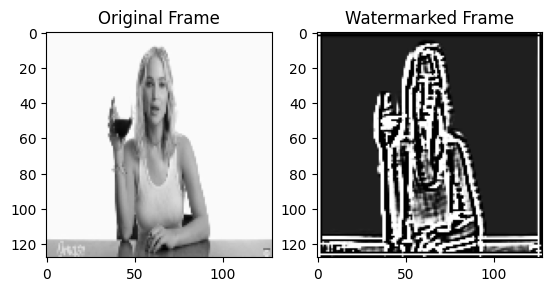

Epoch 1400/5000 - D Loss: 0.6930, G Loss: 0.6619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
📏 Epoch 1400: PSNR = 4.58 dB, SSIM = 0.0506


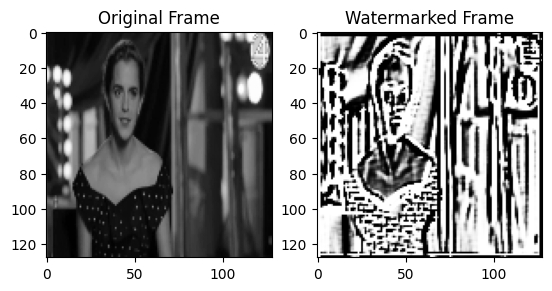

Epoch 1500/5000 - D Loss: 0.6930, G Loss: 0.6615
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
📏 Epoch 1500: PSNR = 6.11 dB, SSIM = 0.0683


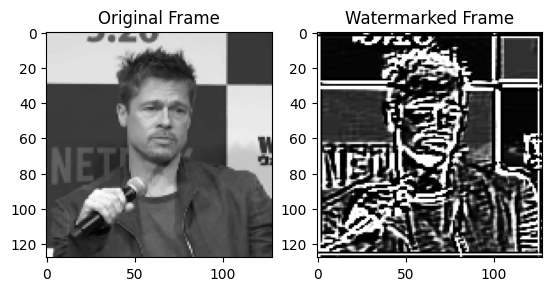

Epoch 1600/5000 - D Loss: 0.6930, G Loss: 0.6611
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 1600: PSNR = 6.42 dB, SSIM = 0.0499


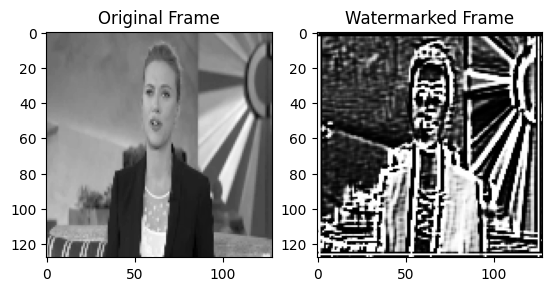

Epoch 1700/5000 - D Loss: 0.6930, G Loss: 0.6608
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 1700: PSNR = 5.92 dB, SSIM = 0.0538


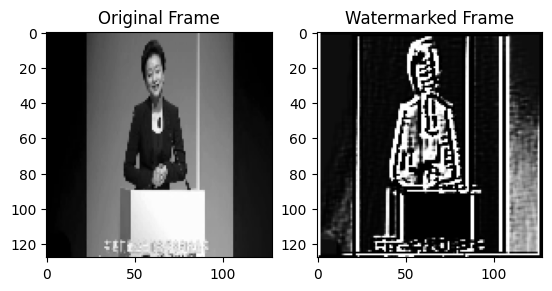

Epoch 1800/5000 - D Loss: 0.6930, G Loss: 0.6604
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
📏 Epoch 1800: PSNR = 4.41 dB, SSIM = 0.0166


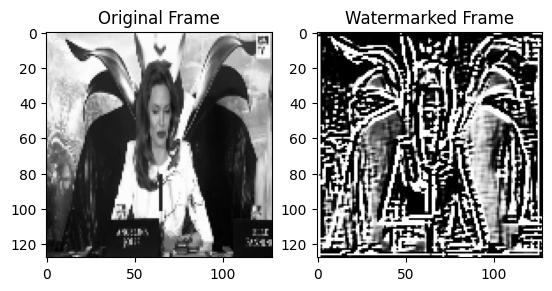

Epoch 1900/5000 - D Loss: 0.6930, G Loss: 0.6601
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
📏 Epoch 1900: PSNR = 4.25 dB, SSIM = 0.0286


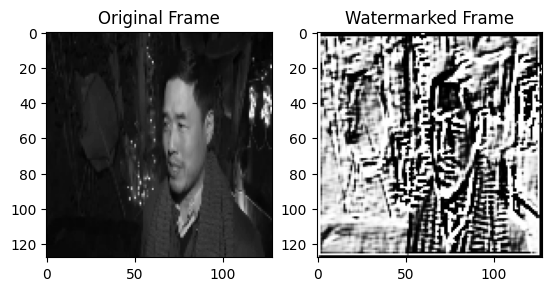

Epoch 2000/5000 - D Loss: 0.6930, G Loss: 0.6598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📏 Epoch 2000: PSNR = 5.32 dB, SSIM = 0.0304


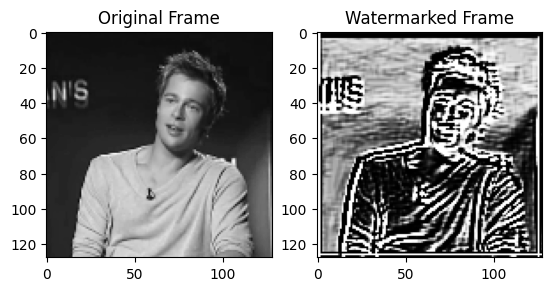

Epoch 2100/5000 - D Loss: 0.6930, G Loss: 0.6594
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
📏 Epoch 2100: PSNR = 7.05 dB, SSIM = 0.0334


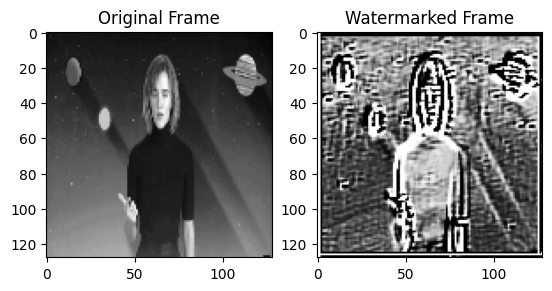

Epoch 2200/5000 - D Loss: 0.6930, G Loss: 0.6591
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 2200: PSNR = 5.46 dB, SSIM = 0.0247


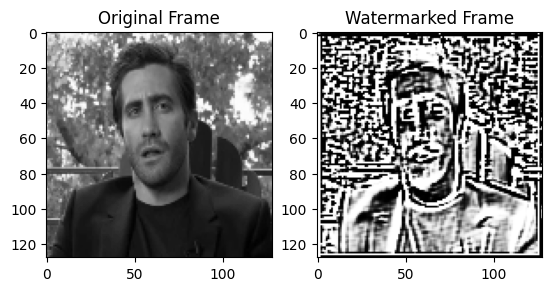

Epoch 2300/5000 - D Loss: 0.6930, G Loss: 0.6588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 2300: PSNR = 6.37 dB, SSIM = 0.0506


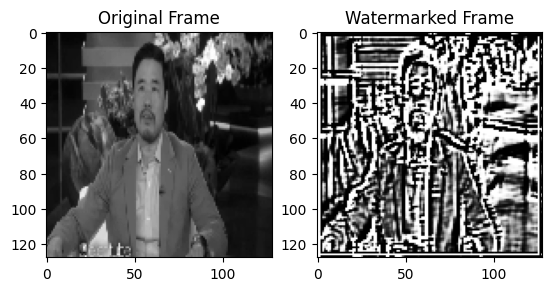

Epoch 2400/5000 - D Loss: 0.6930, G Loss: 0.6585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 2400: PSNR = 1.97 dB, SSIM = 0.0508


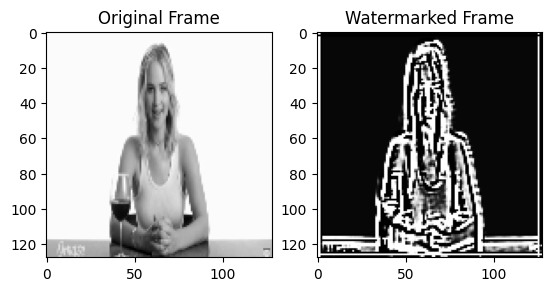

Epoch 2500/5000 - D Loss: 0.6930, G Loss: 0.6582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
📏 Epoch 2500: PSNR = 3.36 dB, SSIM = 0.0232


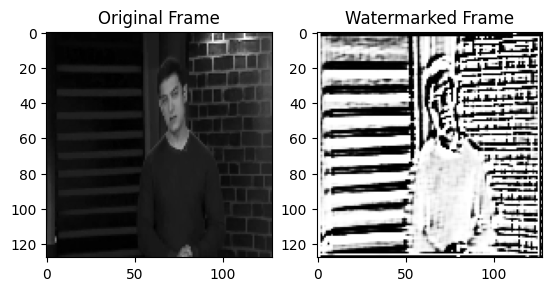

Epoch 2600/5000 - D Loss: 0.6930, G Loss: 0.6579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
📏 Epoch 2600: PSNR = 6.17 dB, SSIM = 0.0320


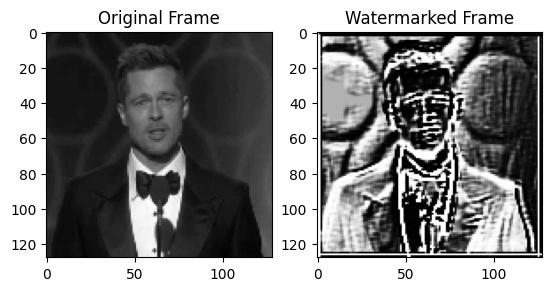

Epoch 2700/5000 - D Loss: 0.6930, G Loss: 0.6576
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 2700: PSNR = 4.84 dB, SSIM = 0.0319


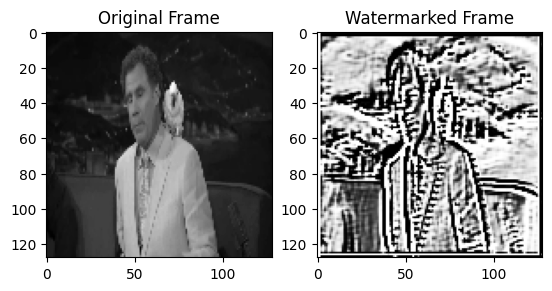

Epoch 2800/5000 - D Loss: 0.6930, G Loss: 0.6573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 2800: PSNR = 5.21 dB, SSIM = 0.0072


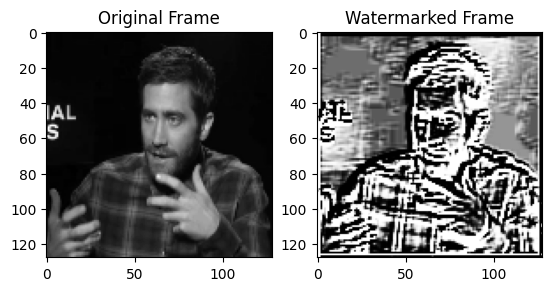

Epoch 2900/5000 - D Loss: 0.6930, G Loss: 0.6570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📏 Epoch 2900: PSNR = 3.02 dB, SSIM = 0.0394


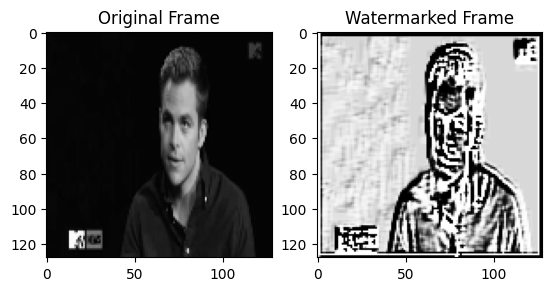

Epoch 3000/5000 - D Loss: 0.6930, G Loss: 0.6567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
📏 Epoch 3000: PSNR = 5.27 dB, SSIM = 0.0187


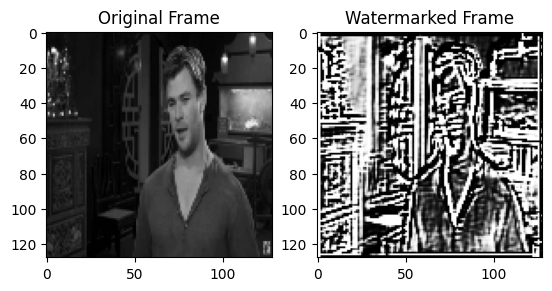

Epoch 3100/5000 - D Loss: 0.6930, G Loss: 0.6564
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 3100: PSNR = 5.86 dB, SSIM = 0.0662


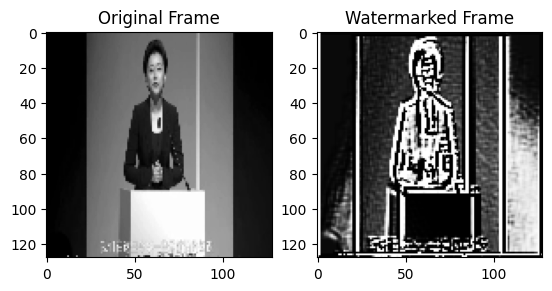

Epoch 3200/5000 - D Loss: 0.6930, G Loss: 0.6561
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📏 Epoch 3200: PSNR = 4.87 dB, SSIM = 0.0201


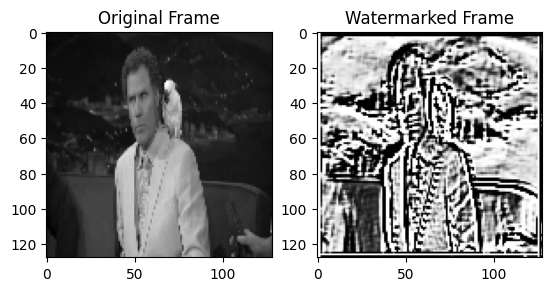

Epoch 3300/5000 - D Loss: 0.6930, G Loss: 0.6558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 3300: PSNR = 6.00 dB, SSIM = 0.0408


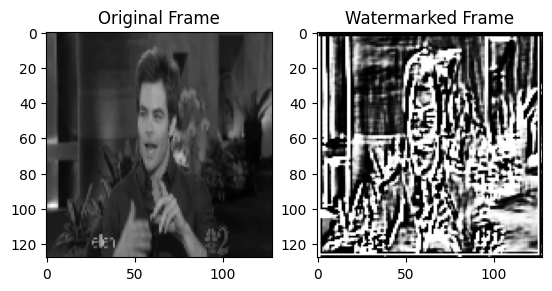

Epoch 3400/5000 - D Loss: 0.6930, G Loss: 0.6555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 3400: PSNR = 5.04 dB, SSIM = 0.0502


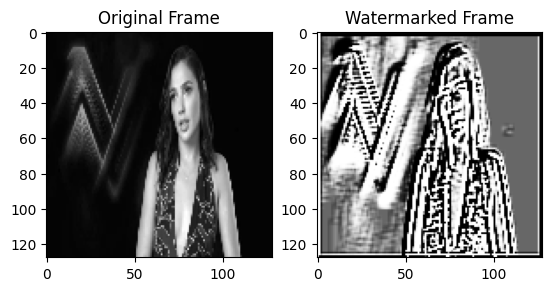

Epoch 3500/5000 - D Loss: 0.6930, G Loss: 0.6552
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 3500: PSNR = 7.87 dB, SSIM = 0.0287


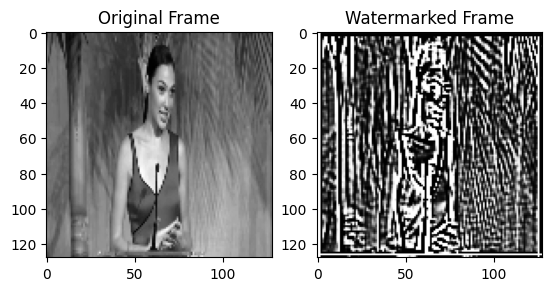

Epoch 3600/5000 - D Loss: 0.6930, G Loss: 0.6550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 3600: PSNR = 4.31 dB, SSIM = 0.0029


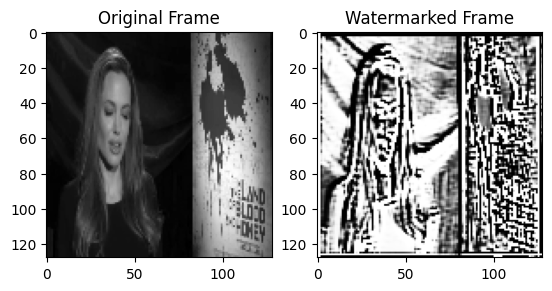

Epoch 3700/5000 - D Loss: 0.6930, G Loss: 0.6547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
📏 Epoch 3700: PSNR = 4.94 dB, SSIM = 0.0585


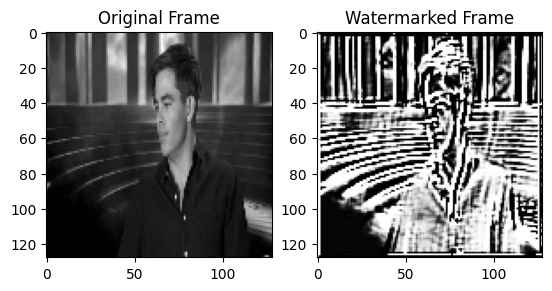

Epoch 3800/5000 - D Loss: 0.6930, G Loss: 0.6544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
📏 Epoch 3800: PSNR = 5.27 dB, SSIM = 0.0349


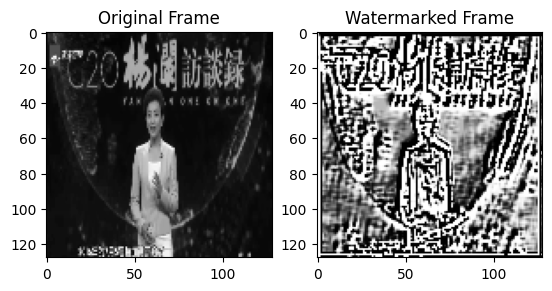

Epoch 3900/5000 - D Loss: 0.6930, G Loss: 0.6541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 3900: PSNR = 8.14 dB, SSIM = 0.0261


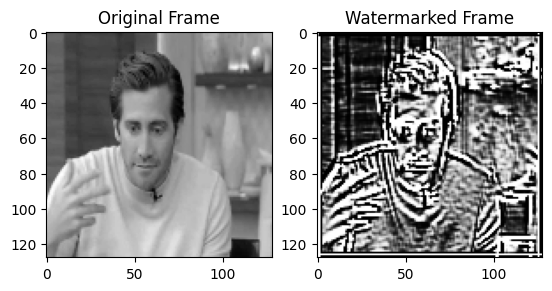

Epoch 4000/5000 - D Loss: 0.6930, G Loss: 0.6538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 4000: PSNR = 5.55 dB, SSIM = 0.0321


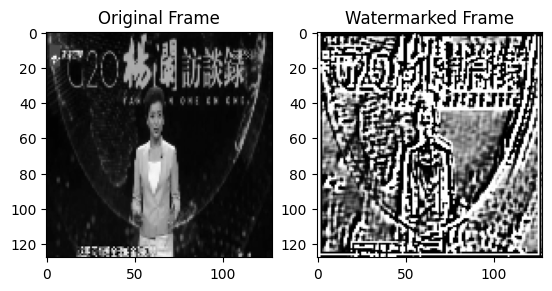

Epoch 4100/5000 - D Loss: 0.6930, G Loss: 0.6535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 4100: PSNR = 7.56 dB, SSIM = 0.0365


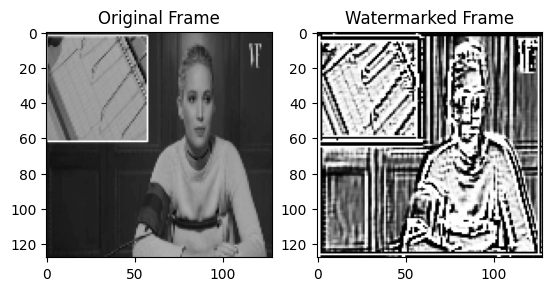

Epoch 4200/5000 - D Loss: 0.6930, G Loss: 0.6533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📏 Epoch 4200: PSNR = 7.70 dB, SSIM = 0.0730


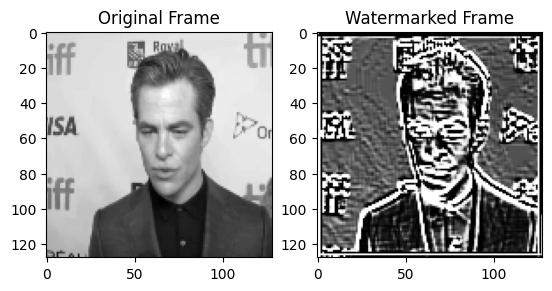

Epoch 4300/5000 - D Loss: 0.6930, G Loss: 0.6530
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 4300: PSNR = 5.16 dB, SSIM = 0.0236


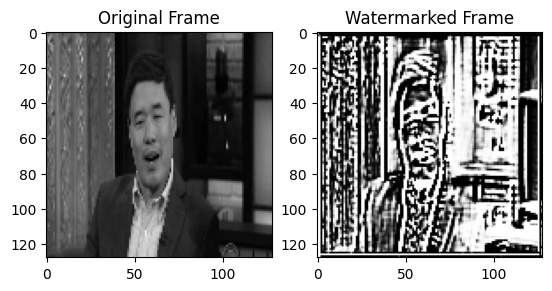

Epoch 4400/5000 - D Loss: 0.6930, G Loss: 0.6527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
📏 Epoch 4400: PSNR = 5.64 dB, SSIM = 0.0196


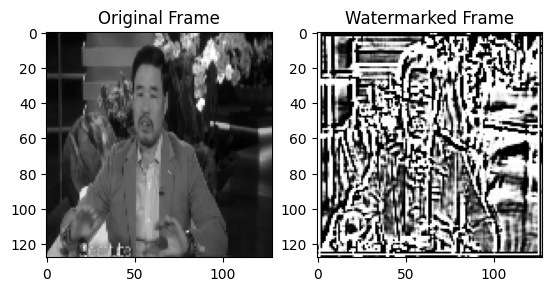

Epoch 4500/5000 - D Loss: 0.6930, G Loss: 0.6524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 4500: PSNR = 5.76 dB, SSIM = 0.0316


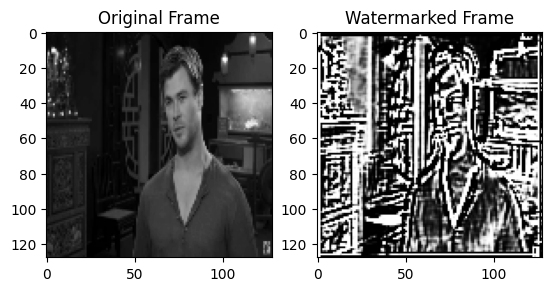

Epoch 4600/5000 - D Loss: 0.6930, G Loss: 0.6521
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 4600: PSNR = 7.10 dB, SSIM = 0.0356


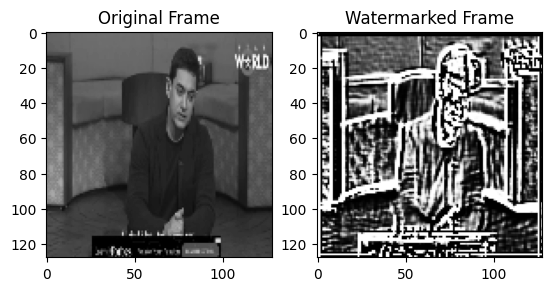

Epoch 4700/5000 - D Loss: 0.6930, G Loss: 0.6519
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
📏 Epoch 4700: PSNR = 5.80 dB, SSIM = 0.0348


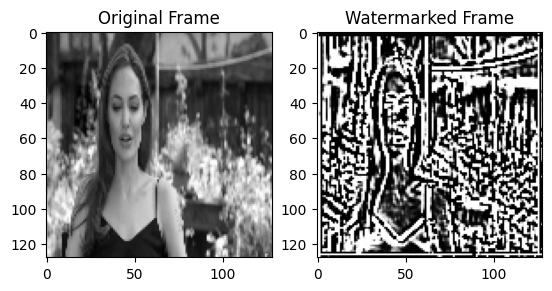

Epoch 4800/5000 - D Loss: 0.6930, G Loss: 0.6516
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 4800: PSNR = 6.80 dB, SSIM = 0.0463


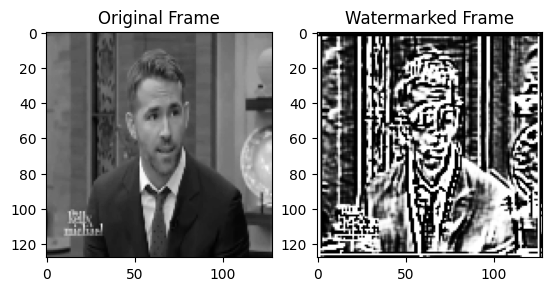

Epoch 4900/5000 - D Loss: 0.6930, G Loss: 0.6513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 4900: PSNR = 5.33 dB, SSIM = 0.0244


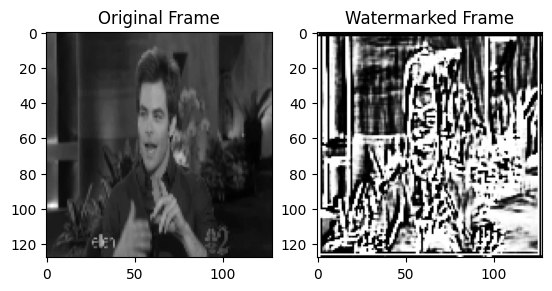

In [10]:
from skimage.metrics import structural_similarity as ssim

weights_dir = "model_weights"
os.makedirs(weights_dir, exist_ok=True)

epochs = 5000
batch_size = 32

real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
    idx = np.random.randint(0, real_images.shape[0], batch_size)
    real_imgs = real_images[idx]
    watermarked_imgs = watermarked_images[idx]

    d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
    d_loss_fake = discriminator.train_on_batch(watermarked_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = gan_model.train_on_batch(real_imgs, real_labels)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - D Loss: {d_loss[0]:.4f}, G Loss: {g_loss:.4f}")

        # Save model weights
        discriminator.save_weights(os.path.join(weights_dir, f"discriminator_epoch_{epoch}.weights.h5"))
        generator.save_weights(os.path.join(weights_dir, f"generator_epoch_{epoch}.weights.h5"))
        gan_model.save_weights(os.path.join(weights_dir, f"gan_model_epoch_{epoch}.weights.h5"))

        # Select a sample frame for evaluation
        sample_idx = np.random.randint(0, real_images.shape[0])
        sample_input = np.expand_dims(real_images[sample_idx], axis=0)
        generated_output = generator.predict(sample_input)[0]

        # Compute PSNR
        def compute_psnr(original, generated):
            mse = np.mean((original - generated) ** 2)
            if mse == 0:
                return 100
            max_pixel = 1.0  # Since images are normalized to [0,1]
            return 20 * np.log10(max_pixel / np.sqrt(mse))

        psnr_value = compute_psnr(real_images[sample_idx].squeeze(), generated_output.squeeze())

        # Compute SSIM
        ssim_value = ssim(real_images[sample_idx].squeeze(), generated_output.squeeze(), data_range=1.0)

        print(f"📏 Epoch {epoch}: PSNR = {psnr_value:.2f} dB, SSIM = {ssim_value:.4f}")

        # Display images
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(real_images[sample_idx].squeeze(), cmap="gray")
        axs[0].set_title("Original Frame")
        axs[1].imshow(generated_output.squeeze(), cmap="gray")
        axs[1].set_title("Watermarked Frame")
        plt.show()


Extract Watermark from Watermarked Video Frames

In [11]:
def extract_watermark(watermarked_image, original_LL):
    extracted_LL, _, _, _, _ = apply_dwt(watermarked_image)

    dct_extracted_LL = apply_dct(extracted_LL)

    alpha = 0.05
    extracted_watermark = (dct_extracted_LL - apply_dct(original_LL)) / alpha

    extracted_watermark = np.clip(extracted_watermark, 0, 255).astype(np.uint8)
    
    return extracted_watermark

frame_folder = "extracted_frames/Celeb-real"
video_folders = [f for f in os.listdir(frame_folder) if os.path.isdir(os.path.join(frame_folder, f))]
selected_video = random.choice(video_folders)
video_path = os.path.join(frame_folder, selected_video)
frame_files = [f for f in os.listdir(video_path) if f.endswith(".jpg") or f.endswith(".png")]
sample_frame_path = os.path.join(video_path, random.choice(frame_files))

watermarked_image = cv2.imread(sample_frame_path, cv2.IMREAD_GRAYSCALE)
if watermarked_image is None:
    raise ValueError("Error loading watermarked image.")

LL, _, _, _, _ = apply_dwt(watermarked_image)
extracted_watermark = extract_watermark(watermarked_image, LL)

cv2.imwrite("extracted_watermark.jpg", extracted_watermark)

print("Watermark extraction completed. Check extracted_watermark.jpg")

Watermark extraction completed. Check extracted_watermark.jpg


Validate Against Modified (Deepfake) Videos

In [12]:
def deepfake_attack(image):
    noise = np.random.normal(0, 25, image.shape)
    fake_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return fake_image

deepfake_frame = deepfake_attack(watermarked_image)

extracted_watermark_fake = extract_watermark(deepfake_frame, LL)

cv2.imwrite("extracted_watermark_fake.jpg", extracted_watermark_fake)

print("Deepfake attack simulated. Extracted watermark from fake frame saved.")

Deepfake attack simulated. Extracted watermark from fake frame saved.


CNN to Validate Deepfake Detection

In [13]:
extracted_watermark_resized = cv2.resize(extracted_watermark, (50, 50))
extracted_watermark_fake_resized = cv2.resize(extracted_watermark_fake, (50, 50))

X_train = np.array([
    extracted_watermark_resized.reshape(50, 50, 1),
    extracted_watermark_fake_resized.reshape(50, 50, 1)
])

X_train = X_train.astype("float32") / 255.0  

y_train = np.array([1, 0])  

print("Dataset prepared successfully. Training CNN model now...")

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(50,50,1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=50, batch_size=2)

print("Deepfake validation model trained successfully.")

Dataset prepared successfully. Training CNN model now...
Epoch 1/50


C:\Users\siddh\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step - accuracy: 0.5000 - loss: 0.6820
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5000 - loss: 0.3601
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5000 - loss: 0.3488
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.3445
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.3414
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.3349
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.3245
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.3099
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.2910
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.2680
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.2415
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.2120
Epoch 13/50

Compute PSNR (Visual Quality Assessment)

In [14]:
def compute_psnr(original, watermarked):
    watermarked_resized = cv2.resize(watermarked, (original.shape[1], original.shape[0]))

    mse = np.mean((original - watermarked_resized) ** 2)
    if mse == 0:
        return 100 
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

original_frame = cv2.imread(sample_frame_path, cv2.IMREAD_GRAYSCALE)
watermarked_frame = cv2.imread("watermarked_frame.jpg", cv2.IMREAD_GRAYSCALE)

psnr_value = compute_psnr(original_frame, watermarked_frame)
print(f"PSNR Value: {psnr_value:.2f} dB")

PSNR Value: 27.90 dB


Evaluate Classification Accuracy (CNN Model)

In [15]:
X_test = np.array([
    extracted_watermark_resized.reshape(50, 50, 1),
    extracted_watermark_fake_resized.reshape(50, 50, 1)
])
X_test = X_test.astype("float32") / 255.0
y_test = np.array([1, 0])

predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Model Accuracy: 100.00%


Robustness Analysis (Testing Attacks)

1. JPEG Compression Attack

In [16]:
compressed_path = "compressed_frame.jpg"
cv2.imwrite(compressed_path, watermarked_frame, [cv2.IMWRITE_JPEG_QUALITY, 50])

compressed_frame = cv2.imread(compressed_path, cv2.IMREAD_GRAYSCALE)

original_LL, _, _, _, _ = apply_dwt(watermarked_frame)
extracted_wm_compressed = extract_watermark(compressed_frame, original_LL)

psnr_compressed = compute_psnr(watermarked_frame, compressed_frame)
print(f"PSNR After Compression: {psnr_compressed:.2f} dB")

PSNR After Compression: 42.62 dB


2. Blurring Attack

In [18]:
blurred_frame = cv2.GaussianBlur(watermarked_frame, (5,5), 0)

extracted_wm_blurred = extract_watermark(blurred_frame, original_LL)

psnr_blurred = compute_psnr(watermarked_frame, blurred_frame)
print(f"PSNR After Blurring: {psnr_blurred:.2f} dB")

PSNR After Blurring: 39.45 dB
